In [25]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim
import torch.nn.functional as F

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [26]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [27]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test", "BH_n4_M10_test"] #The labels in the hdf5 dataset
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #For plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
N_EVENTS = [15000, 15000]
MAX_EVENTS = 3000
CUT=False
#Set data paths
if CUT:
    FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
else:
    FILENAMES = [f"{label}_res{RES}_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{FILENAMES[i]}" for i in range(CLASSES)]

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
ampl.use_atlas_style()  
filters=None#["saturate"] 
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

Running on the GPU


In [28]:
def add_images(data, axis, device):
    size=100
    dataset = DataLoader(data, size, shuffle=False)
    image = torch.zeros([size, 50, 50]).to(device)
    for data in tqdm(dataset):
        X, y = data
        event = X[:,:,:,axis].view(len(X), 50,50)
        image = torch.add(image, event)
    image = torch.sum(image, dim=0)
    print(image.size)
    return(image)

def maximum_value(data, axis, device):
    dataset = DataLoader(data, 1, shuffle=False)
    max_values = torch.zeros(len(dataset)).to(device)
    i = 0
    for data in tqdm(dataset):
        X, y = data
        event = X[:,:,:,axis].view(50,50)
        max_values[i] = torch.max(event)
        i = i + 1
    return(max_values)

def middle_value(data, axis, device):
    dataset = DataLoader(data, 1, shuffle=False)
    middle_values = torch.zeros(len(dataset)).to(device)
    i = 0
    for data in tqdm(dataset):
        X, y = data
        middle_values[i] = X[:,:,:,axis].view(50,50)[25, 2]
        i = i + 1
    return(middle_values)

In [29]:
#load data in memory
sph_path = [Path(DATAPATHS[0])]
bh_path = [Path(DATAPATHS[1])]
print(sph_path, bh_path)
#Load lazily
sph_data = Hdf5Dataset(sph_path, LABELS, DEVICE, shuffle=False, filters=filters, 
                        max_value = 20000, transform=None, event_limit=MAX_EVENTS)
bh_data = Hdf5Dataset(bh_path, LABELS, DEVICE, shuffle=False, filters=filters, 
                        max_value = 20000, transform=None, event_limit=MAX_EVENTS)

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_15000_events.h5')] [PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_15000_events.h5')]


In [30]:
all_data = [sph_data, bh_data]
images = np.zeros((CLASSES, 3, 50,50))

for i in range(CLASSES):
    for j in range(3):
        images[i][j] = add_images(all_data[i], j, DEVICE).cpu()

100%|██████████| 30/30 [00:02<00:00, 13.48it/s]


<built-in method size of Tensor object at 0x7f3b9c0dfc70>


100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


<built-in method size of Tensor object at 0x7f3b9c0dfc70>


100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


<built-in method size of Tensor object at 0x7f3b3d64b2c0>


100%|██████████| 30/30 [00:02<00:00, 13.55it/s]


<built-in method size of Tensor object at 0x7f3b3d615a90>


100%|██████████| 30/30 [00:02<00:00, 14.48it/s]


<built-in method size of Tensor object at 0x7f3bb02d7310>


100%|██████████| 30/30 [00:02<00:00, 14.46it/s]

<built-in method size of Tensor object at 0x7f3b9c0c4b30>


In [31]:
#images[1][2][25][25] = 0

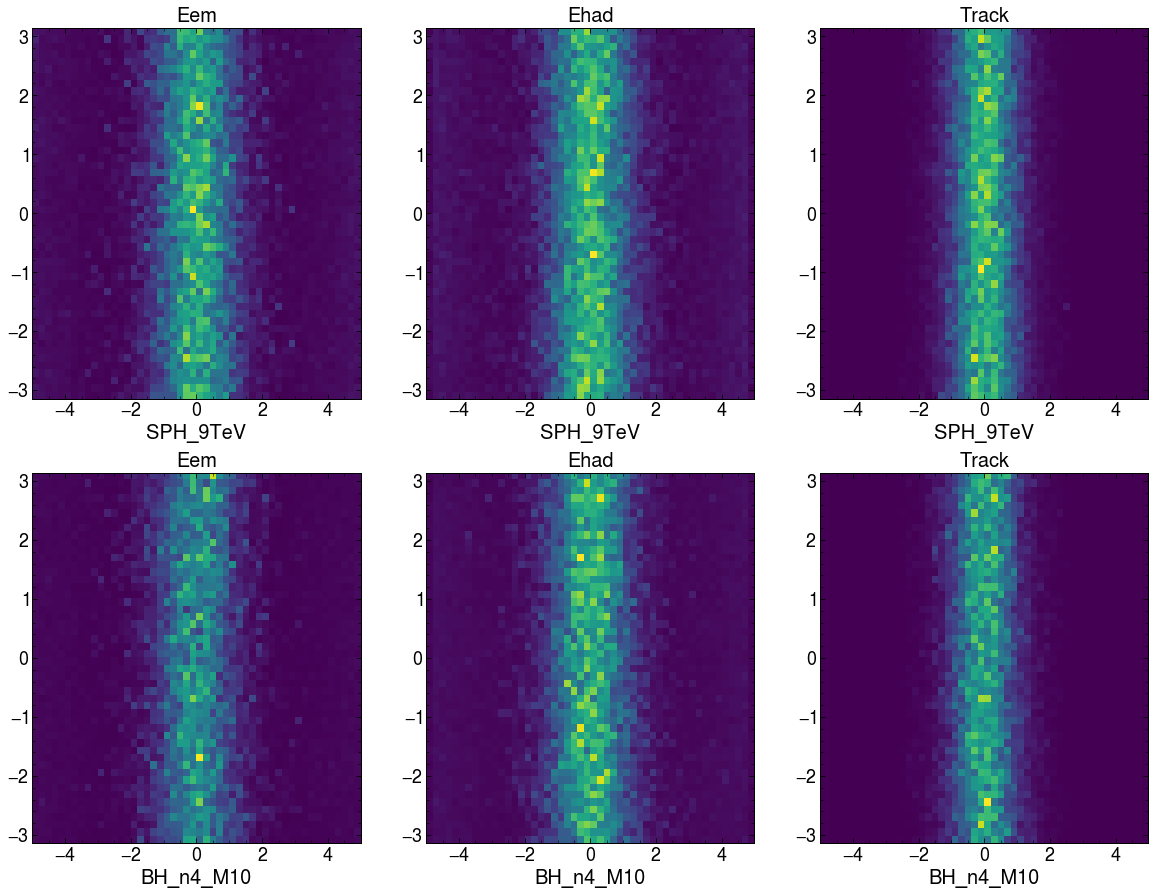

In [32]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 15))
layer_labels = ["Eem", "Ehad", "Track"]
for i in range(CLASSES):
    for j in range(3):
        axs[i][j].imshow(images[i][j], extent=[-5, 5, -np.pi, np.pi], aspect='auto')
        axs[i][j].set_xlabel(PLOT_LABELS[i])
        axs[i][j].set_title(layer_labels[j])


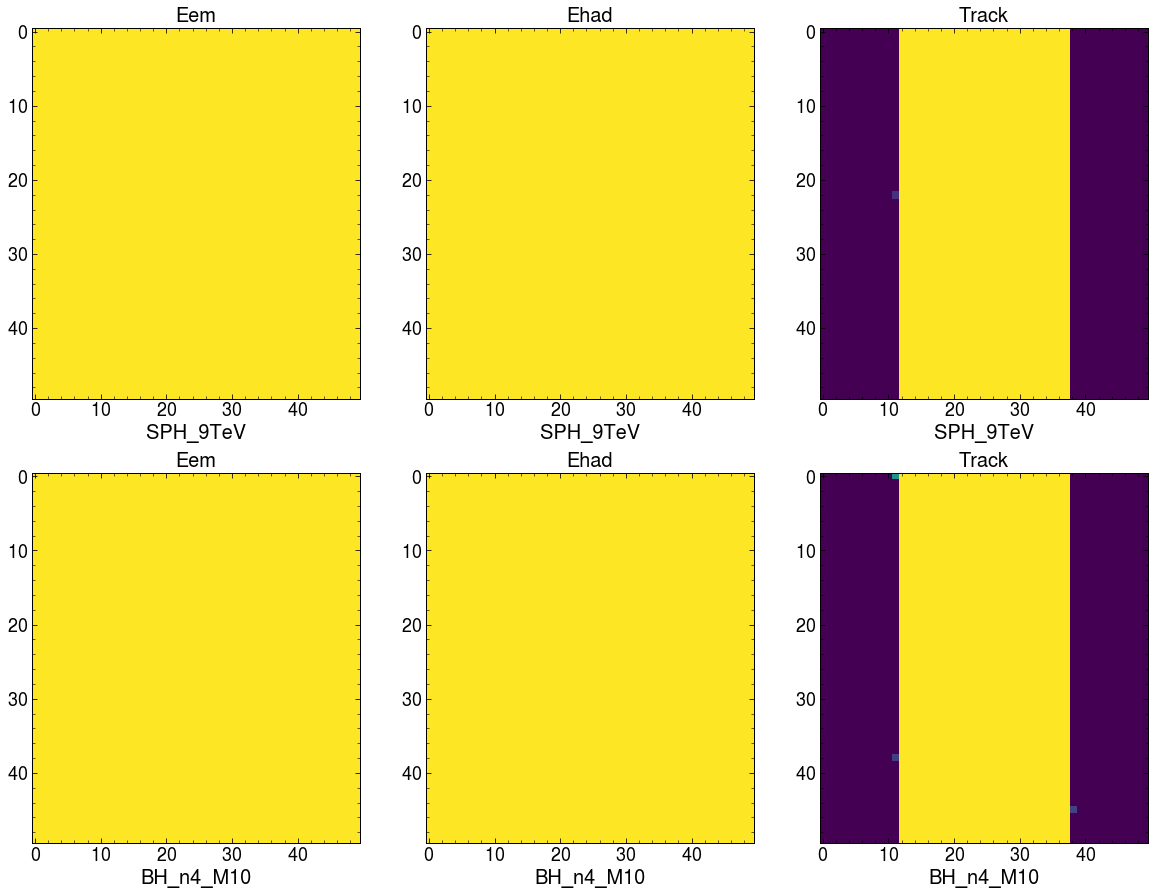

In [33]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 15))
for i in range(CLASSES):
    for j in range(3):
        axs[i][j].imshow(images[i][j], vmin=0, vmax=1, aspect='auto')
        axs[i][j].set_xlabel(PLOT_LABELS[i])
        axs[i][j].set_title(layer_labels[j])


In [34]:
print(images[1][2][25][2])

0.0


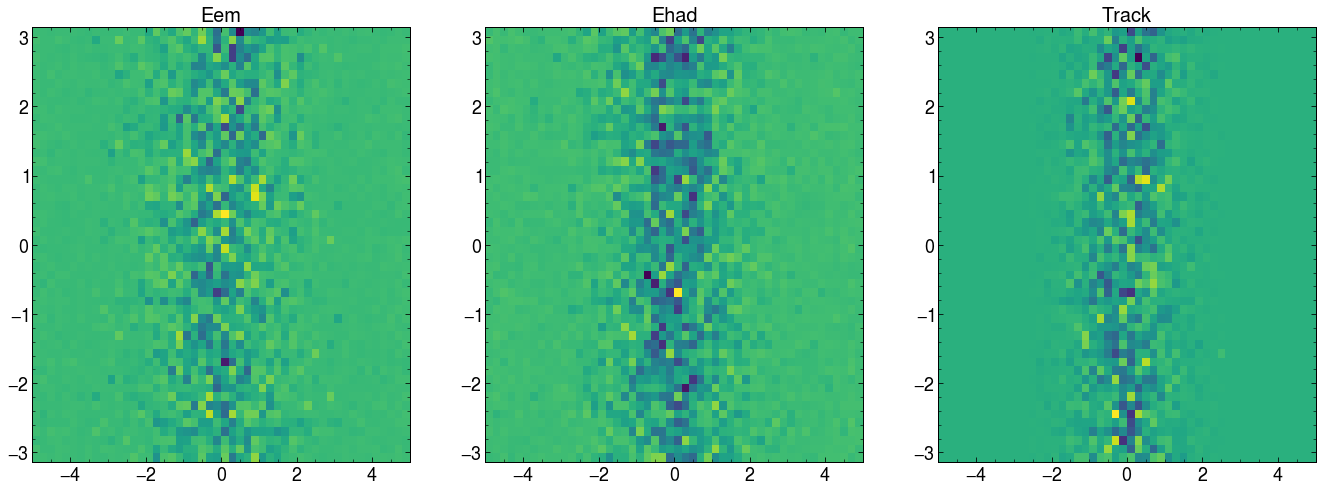

In [35]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (23, 8))
layer_labels = ["Eem", "Ehad", "Track"]
for j in range(3):
    axs[j].imshow(images[0][j] - images[1][j], extent=[-5, 5, -np.pi, np.pi], aspect='auto')
    axs[j].set_title(layer_labels[j])


In [36]:
max_values = np.zeros((CLASSES, MAX_EVENTS))

for i in range(CLASSES):
    max_values[i] = maximum_value(all_data[i], 2, DEVICE).cpu()

100%|██████████| 3000/3000 [00:02<00:00, 1011.49it/s]


Text(0.5, 1.0, 'Black holes track')

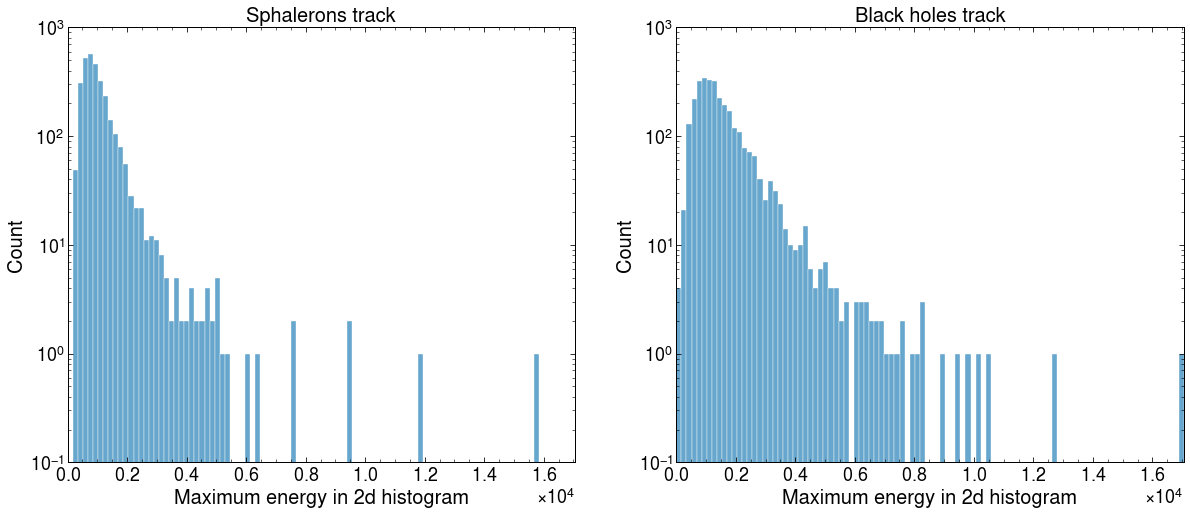

In [37]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
max_energy = np.max(max_values.flatten())
sn.histplot(max_values[0], ax = axs[0], binrange=(0, max_energy), bins=100)
sn.histplot(max_values[1], ax = axs[1], binrange=(0, max_energy), bins=100)
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[0].set_xlim(0, max_energy)
axs[1].set_xlim(0, max_energy)
axs[0].set_xlabel("Maximum energy in 2d histogram")
axs[1].set_xlabel("Maximum energy in 2d histogram")
axs[0].set_title("Sphalerons track")
axs[1].set_title("Black holes track")

In [38]:
print([np.max(np.max(item)) for item in max_values])
print(len(max_values[0]))
k = np.argmax(max_values.flatten())

[15762.4599609375, 17046.884765625]
3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2615
tensor(17046.8848)


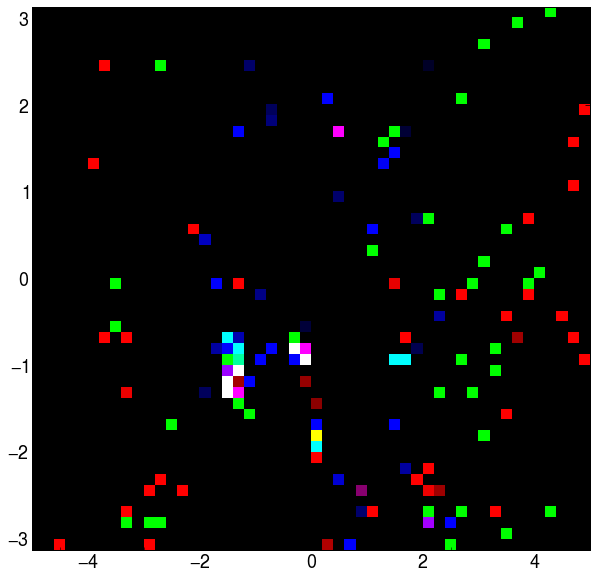

In [39]:
if k>MAX_EVENTS:
    i = k - MAX_EVENTS
print(i)
plt.figure(figsize=(10,10))
plt.imshow(bh_data[i][0].cpu(), extent=[-5, 5, -np.pi, np.pi], aspect='auto')
print(torch.max(bh_data[i][0].cpu()))

In [40]:
middle_values = np.zeros((CLASSES, MAX_EVENTS))

for i in range(CLASSES):
    middle_values[i] = middle_value(all_data[i], 2, DEVICE).cpu()


100%|██████████| 3000/3000 [00:02<00:00, 1073.79it/s]


/tmp/ipykernel_30105/476302702.py:7: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  axs[0].set_xlim(0, max_middle_energy)
/tmp/ipykernel_30105/476302702.py:8: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(0, max_middle_energy)


Text(0.5, 1.0, 'Black holes track')

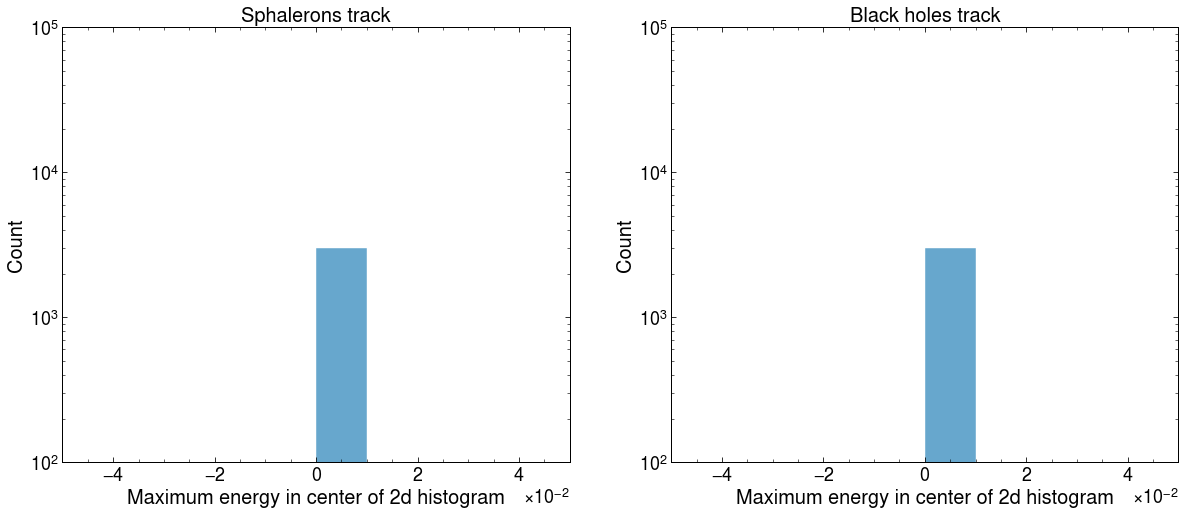

In [41]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
max_middle_energy = np.max(middle_values.flatten())
sn.histplot(middle_values[0], ax = axs[0], binrange=(0, max_middle_energy), bins=100)
sn.histplot(middle_values[1], ax = axs[1], binrange=(0, max_middle_energy), bins=100)
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[0].set_xlim(0, max_middle_energy)
axs[1].set_xlim(0, max_middle_energy)
axs[0].set_xlabel("Maximum energy in center of 2d histogram")
axs[1].set_xlabel("Maximum energy in center of 2d histogram")
axs[0].set_title("Sphalerons track")
axs[1].set_title("Black holes track")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.0, 0.0]
1
tensor(1490.3030)


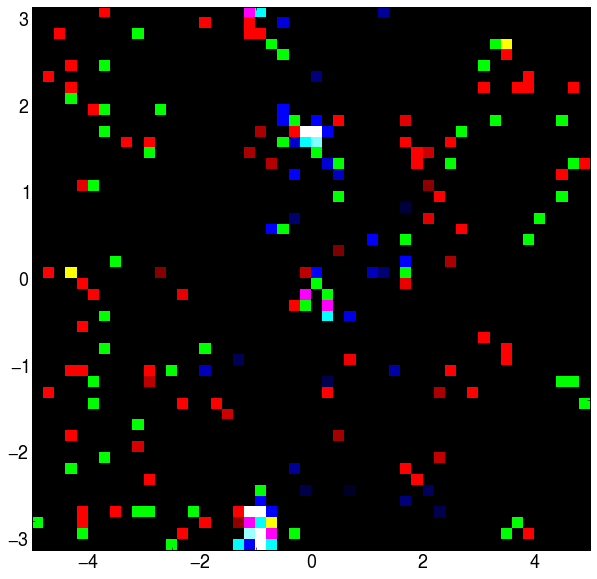

In [42]:
print([np.max(np.max(item)) for item in middle_values])
k = np.argmax(middle_values.flatten())
if k>MAX_EVENTS:
    i = k - MAX_EVENTS
print(i)
plt.figure(figsize=(10,10))
plt.imshow(bh_data[i][0].cpu(), extent=[-5, 5, -np.pi, np.pi], aspect='auto')
print(torch.max(bh_data[i][0].cpu()))